In [1]:
import numpy as np
import pandas as pd
from pyhht import EMD
from scipy import stats 

import datetime
import tensorflow as tf
from keras import models
from keras import layers
from keras import regularizers

In [2]:
max_imf = 15 #maximun number of imfs
num_line = 2 #if 1, only use discharge pressure features; if 2, use discharge and suction pressure features

skew_d = 'skew_d_'
kur_d = 'kur_d_'
skew_s = 'skew_s_'
kur_s = 'kur_s_'

## Load dataset

In [3]:
#fluctuate
df_fluctuate = pd.read_csv("./dataset_resized/dataset_resized_fluctuate.csv")
print(df_fluctuate.shape)

(2837, 66)


In [4]:
#disaster leak
df_fluctuate_leak_disaster = pd.read_csv("./dataset_resized/dataset_resized_fluctuate_leak_disaster.csv")
print(df_fluctuate_leak_disaster.shape)

(2837, 66)


In [5]:
#large leak
df_fluctuate_leak_large = pd.read_csv("./dataset_resized/dataset_resized_fluctuate_leak_large.csv")
print(df_fluctuate_leak_large.shape)

(2837, 66)


In [6]:
#medium leak
df_fluctuate_leak_medium = pd.read_csv("./dataset_resized/dataset_resized_fluctuate_leak_medium.csv")
print(df_fluctuate_leak_medium.shape)

(2837, 66)


In [7]:
#small leak(real)
df_leak_real = pd.read_csv("./dataset_resized/dataset_resized_leak_real.csv")
print(df_leak_real.shape)

(6, 66)


In [8]:
#small leak augment(real)
df_leak_augment = pd.read_csv("./dataset_resized/dataset_resized_leak_augment.csv")
print(df_leak_augment.shape)

(120, 66)


In [9]:
#small leak(artificial synthesis)
df_leak_artificial = pd.read_csv("./dataset_resized/dataset_resized_leak_artificial.csv")
print(df_leak_artificial.shape)

(2244, 66)


In [10]:
#combine these dataset together
df = df_fluctuate.append(df_fluctuate_leak_disaster)\
        .append(df_fluctuate_leak_large).append(df_fluctuate_leak_medium).append(df_leak_real).append(df_leak_augment).append(df_leak_artificial)
df.shape

(13718, 66)

In [11]:
X = df.drop(['file_path', 'date', 'time', 'label', 'segment'], axis=1)

## Feature Correlation Analysis

[Text(0.5, 1.0, 'Correlation heatmap of features')]

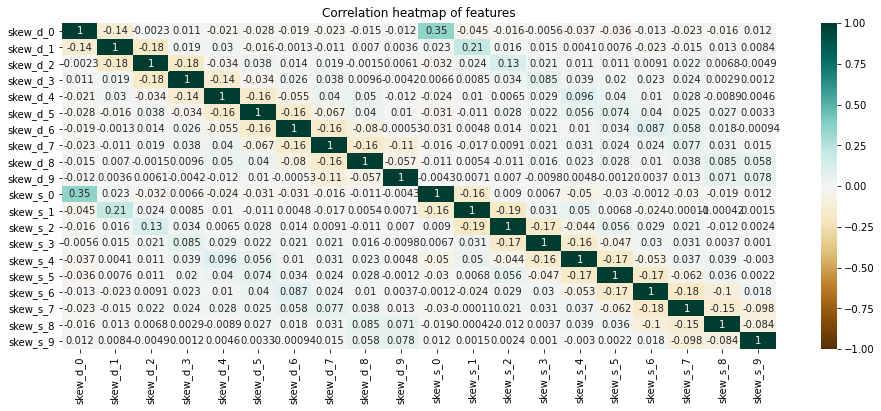

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

X = X.astype('float')

plt.figure(figsize=(16,6))
sns.heatmap(X[['skew_d_0', 'skew_d_1','skew_d_2','skew_d_3','skew_d_4','skew_d_5','skew_d_6','skew_d_7','skew_d_8','skew_d_9', 
               'skew_s_0', 'skew_s_1','skew_s_2','skew_s_3','skew_s_4','skew_s_5','skew_s_6','skew_s_7','skew_s_8','skew_s_9']].corr(method='pearson'), 
            annot=True,cmap='BrBG',
            vmin=-1, vmax=1).set(title = "Correlation heatmap of features")

[Text(0.5, 1.0, 'Correlation heatmap of features')]

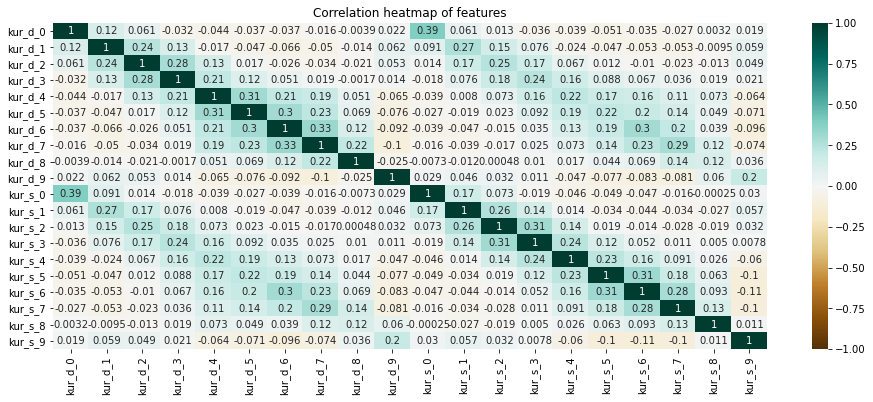

In [13]:
plt.figure(figsize=(16,6))
sns.heatmap(X[['kur_d_0', 'kur_d_1','kur_d_2','kur_d_3','kur_d_4','kur_d_5','kur_d_6','kur_d_7','kur_d_8','kur_d_9',
            'kur_s_0', 'kur_s_1','kur_s_2','kur_s_3','kur_s_4','kur_s_5','kur_s_6','kur_s_7','kur_s_8','kur_s_9']].corr(method='pearson'), 
            annot=True,cmap='BrBG',
            vmin=-1, vmax=1).set(title = "Correlation heatmap of features")

[Text(0.5, 1.0, 'Correlation heatmap of features')]

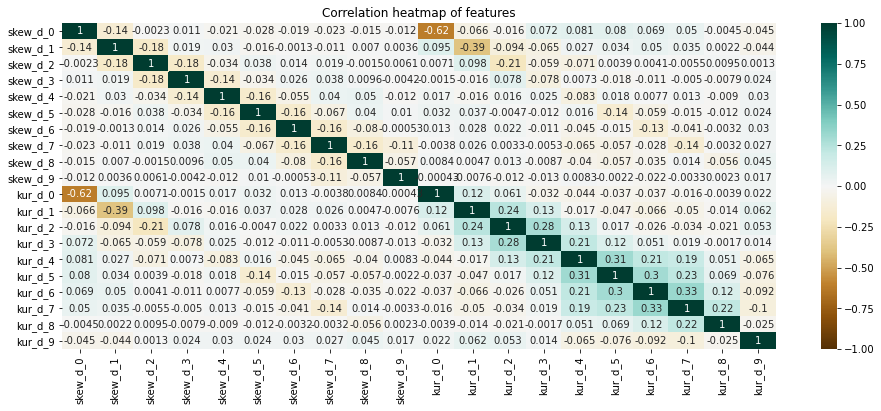

In [14]:
plt.figure(figsize=(16,6))
sns.heatmap(X[['skew_d_0', 'skew_d_1','skew_d_2','skew_d_3','skew_d_4','skew_d_5','skew_d_6','skew_d_7','skew_d_8','skew_d_9', 
               'kur_d_0', 'kur_d_1','kur_d_2','kur_d_3','kur_d_4','kur_d_5','kur_d_6','kur_d_7','kur_d_8','kur_d_9']].corr(method='pearson'), 
            annot=True,cmap='BrBG',
            vmin=-1, vmax=1).set(title = "Correlation heatmap of features")

## Vectorize input features

In [15]:
X.shape

(13718, 61)

In [16]:
def vectorize_sequences(sequences, dimension = num_line*30):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in sequences.iterrows():
        if num_line == 2:
            for j in range(0, max_imf):
                results[i, j] = sequence[skew_d + str(j)]
            for j in range(0, max_imf):
                results[i, j + 15] = sequence[kur_d + str(j)]
            for j in range(0, max_imf):
                results[i, j + 30] = sequence[skew_s + str(j)]
            for j in range(0, max_imf):
                results[i, j + 45] = sequence[kur_s + str(j)]
        elif num_line == 1:
            for j in range(0, max_imf):
                results[i, j] = sequence[skew_d + str(j)]
            for j in range(0, max_imf):
                results[i, j + 15] = sequence[kur_d + str(j)]   
    return results

In [17]:
X_vec = vectorize_sequences(X)
X_vec[0]

array([ 1.72499686e-02, -2.24237578e-01, -8.92194839e-02,  2.21398497e-01,
        3.96599833e-01, -2.32613101e-02, -3.15697460e-01,  1.86323453e-01,
        1.35485878e-01, -1.20139818e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.28378738e-01,
        1.52206773e+00,  4.13091026e-01,  6.40835325e+00,  5.54735352e+00,
        3.86505391e+00,  1.32770635e+00, -4.57998379e-01, -9.27443788e-01,
       -3.83591399e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.12068607e-02, -4.66437604e-01,
       -1.32483745e-01, -5.64926357e-01, -2.92094864e-01, -1.10887979e-02,
       -4.32695048e-01,  1.47167800e-02, -1.41090385e+00,  2.43257725e-01,
       -6.16032721e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.85564539e-01,  5.81353620e+00,  2.57497617e+00,
        1.46230154e+01,  4.02710718e+00,  4.37376788e+00,  1.27848938e+00,
       -7.53153656e-02,  

In [18]:
y = df['label']

y.value_counts()

leak         10881
fluctuate     2837
Name: label, dtype: int64

# Represent labels by using one hot encoding

In [19]:
y_vec = pd.get_dummies(y)# Get one-hot encoding of variable
y_vec

,fluctuate,leak
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
2239,0,1
2240,0,1
2241,0,1
2242,0,1


In [20]:
y_vec = np.array(y_vec)
y_vec

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

# Split datasets into training, development, and test datasets

In [21]:
#split data into train, val, test
from sklearn.model_selection import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(X_vec, y_vec, random_state=37, test_size = 0.2 )
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=47, test_size = 0.2 )

In [22]:
X_train.shape

(8779, 60)

In [23]:
X_val.shape

(2195, 60)

In [24]:
X_test.shape

(2744, 60)

## Fully Connected Model

In [30]:
#Define your callbacks (save your model, patience, etc.)
model_name = "best_model_mnist.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [31]:
#Define model, cost function, optimizer, learning rate
def my_model(ishape = (num_line*30,), k = 2, lr = 1e-4): #ishape: input shape, k: number of lavels, lr: learning rate
    model_input = tf.keras.layers.Input(shape = ishape)
    l1 = tf.keras.layers.Dense(128, activation = 'relu')(model_input)
    l2 = tf.keras.layers.Dense(128, activation = 'relu')(l1)
    l3 = tf.keras.layers.Dense(128, activation = 'relu')(l2)
    out = tf.keras.layers.Dense(k, activation = 'softmax')(l3)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [32]:
model = my_model()
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               7808      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 41,090
Trainable params: 41,090
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
#Train model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(X_train,y_train,batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule, tensorboard_callback],validation_data=(X_val,y_val))

Epoch 1/1000
275/275 [==============================] - 1s 3ms/step - loss: 0.5884 - accuracy: 0.9422 - val_loss: 0.5211 - val_accuracy: 1.0000
Epoch 2/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5015 - accuracy: 1.0000 - val_loss: 0.3962 - val_accuracy: 1.0000
Epoch 3/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.3422 - accuracy: 1.0000 - val_loss: 0.1626 - val_accuracy: 0.9995
Epoch 4/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.1276 - accuracy: 0.9990 - val_loss: 0.0508 - val_accuracy: 1.0000
Epoch 5/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.0427 - accuracy: 0.9991 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 6/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.0181 - accuracy: 0.9999 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 7/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy:

275/275 [==============================] - 0s 1ms/step - loss: 8.9741e-06 - accuracy: 1.0000 - val_loss: 6.7593e-06 - val_accuracy: 1.0000
Epoch 109/1000
275/275 [==============================] - 0s 1ms/step - loss: 5.8081e-06 - accuracy: 1.0000 - val_loss: 6.7575e-06 - val_accuracy: 1.0000
Epoch 110/1000
275/275 [==============================] - 0s 1ms/step - loss: 6.5374e-06 - accuracy: 1.0000 - val_loss: 6.7559e-06 - val_accuracy: 1.0000
Epoch 111/1000
275/275 [==============================] - ETA: 0s - loss: 7.0443e-06 - accuracy: 1.00 - 0s 1ms/step - loss: 7.0427e-06 - accuracy: 1.0000 - val_loss: 6.7562e-06 - val_accuracy: 1.0000
Epoch 112/1000
275/275 [==============================] - 0s 1ms/step - loss: 6.0941e-06 - accuracy: 1.0000 - val_loss: 6.7566e-06 - val_accuracy: 1.0000
Epoch 113/1000
275/275 [==============================] - 0s 1ms/step - loss: 6.5320e-06 - accuracy: 1.0000 - val_loss: 6.7570e-06 - val_accuracy: 1.0000
Epoch 114/1000
275/275 [=====================

In [34]:
#Test model on the test and extract relevant metrics
model.load_weights(model_name)
result = model.evaluate(X_test,y_test)

86/86 [==============================] - 0s 647us/step - loss: 0.2277 - accuracy: 0.9993
